In [1]:
import numpy as np
import pandas as pd
import feather

import statsmodels.api as sm
from statsmodels.formula.api import ols
from stargazer.stargazer import Stargazer
 


In [2]:
btcp=pd.read_feather('~/Documents/Data/btc_price_fred.feather')
usdc=pd.read_feather('~/Documents/Data/cmc_usdc_marketcap.feather')
tether=pd.read_feather('~/Documents/Data/cmc_usdt_marketcap.feather')
stb=pd.merge(usdc,tether,left_index=True,right_index=True,suffixes=("","USDT"))
df=pd.merge(btcp,stb,left_index=True,right_index=True).rename(columns={'CBBTCUSD':'btc'})

df=df.reset_index().rename(columns={'index':'date'})
df['marketcap']=df.marketcap/1e9
df['volume']=df.volume/1e9
df['marketcapUSDT']=df.marketcapUSDT/1e9
df['volumeUSDT']=df.volumeUSDT/1e9
df=df.loc[df.date>='2021-01-01']


# Load your data into the 'df' DataFrame
# df = # Your data loading code here

# Ensure 'date' is in pandas datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort the DataFrame by date to ensure correct diff calculations
df = df.sort_values(by='date')
df.set_index('date', inplace=True)


In [3]:
mb=pd.read_csv('~/Documents/Data/customermintburnall.csv')
mb['date']=pd.to_datetime(mb.DS)
#mb['date_wk']=pd.to_datetime(mb.DS_WEEK)
#mba=mb.groupby('date_wk').agg({'MINT_AMT':sum, 'BURN_AMT':sum})
mbdaily=mb.groupby('date').agg({'MINT_AMT':sum, 'BURN_AMT':sum}).rename(columns={'MINT_AMT':'mint','BURN_AMT':'burn'})
df2=pd.merge(df,mbdaily/1e9,left_index=True,right_index=True)
df2['gross']=df2.mint+df2.burn

/var/folders/n8/fg13rkv5657f2xncnz3kq_jc0000gn/T/ipykernel_46697/422735875.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mb=pd.read_csv('~/Documents/Data/customermintburnall.csv')
/var/folders/n8/fg13rkv5657f2xncnz3kq_jc0000gn/T/ipykernel_46697/422735875.py:5: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  mbdaily=mb.groupby('date').agg({'MINT_AMT':sum, 'BURN_AMT':sum}).rename(columns={'MINT_AMT':'mint','BURN_AMT':'burn'})


In [4]:
ta=pd.read_csv('~/Documents/Data/tokenactivitiesmonthly.csv')

In [5]:
ta['date']=pd.to_datetime(ta['ds'])
ta = ta.drop(columns=['ds'])


In [6]:
taw=ta.set_index(['date','token']).unstack()
taw.columns = ['_'.join([str(col[1]), str(col[0])]).rstrip('_') for col in taw.columns.values]

<Axes: xlabel='date'>

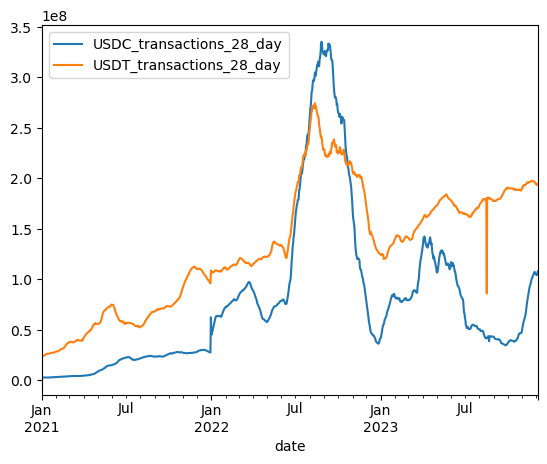

In [7]:
taw[['USDC_transactions_28_day','USDT_transactions_28_day']].plot()

<Axes: xlabel='date'>

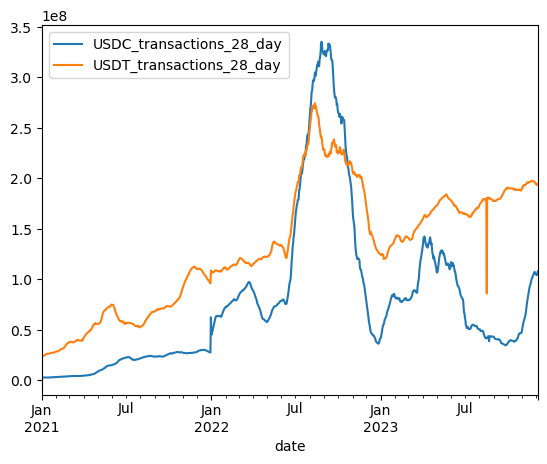

In [ ]:
taw[['USDC_transactions_28_day','USDT_transactions_28_day']].plot()

In [114]:
df3=pd.merge(df2,taw/1e9,left_index=True,right_index=True)

In [106]:
df2=df2.sort_index()#.loc['2023-03-31':]
weekly_df = df2.resample('W').agg({
    'btc': 'last',  # Last observation for btc
    'marketcap': 'last',  # Last observation for marketcap
    'volume': 'sum',  # Sum for volume
    'volumeUSDT': 'sum',  # Sum for volumeUSDT
    'gross': 'sum',  # Sum for gross
    'marketcapUSDT': 'last'  # Assume marketcapUSDT also uses the last observation
})
weekly_df['btc_log_change'] = np.log(weekly_df['btc']).diff()
weekly_df['volume_change'] = weekly_df['volume'].diff()
weekly_df['volumeUSDT_change'] = weekly_df['volumeUSDT'].diff()
weekly_df['marketcap_change'] = weekly_df['marketcap'].diff()
weekly_df['marketcapUSDT_change'] = weekly_df['marketcapUSDT'].diff()
weekly_df['gross_change']=weekly_df['gross'].diff()


weekly_df['btc_log_change_positive'] = weekly_df['btc_log_change'].apply(lambda x: x if x > 0 else 0)
weekly_df['btc_log_change_negative'] = weekly_df['btc_log_change'].apply(lambda x: x if x < 0 else 0)

weekly_df['gross_change_positive'] = weekly_df['gross_change'].apply(lambda x: x if x > 0 else 0)
weekly_df['gross_change_negative'] = weekly_df['gross_change'].apply(lambda x: x if x < 0 else 0)
# Drop the NA values generated by diff
weekly_df.dropna(inplace=True)

# Create the post-March 2023 dummy variable
threshold_date = pd.to_datetime('2023-03-31')
weekly_df['post_march_2023'] = (weekly_df.index > threshold_date).astype(int)

# Define regression models
# model1 = ols('marketcap_change ~ btc_log_change + volume_change + gross_change_change', data=weekly_df).fit()
models=[]
models.append(ols('marketcap_change ~ btc_log_change + volume+volume_change + gross_change', data=weekly_df).fit())
models.append(ols('marketcapUSDT_change ~ btc_log_change + volumeUSDT+ volumeUSDT_change + gross_change', data=weekly_df).fit())
models.append(ols('marketcap_change ~ (btc_log_change + volume+volume_change + gross_change)', data=weekly_df.loc['2023-03-31':]).fit())
models.append(ols('marketcapUSDT_change ~ (btc_log_change + volumeUSDT+ volumeUSDT_change + gross_change)', data=weekly_df.loc['2023-03-31':]).fit())
# models.append(ols('marketcap_change ~ (btc_log_change +  gross_change)', data=weekly_df.loc['2023-03-31':]).fit())
# models.append(ols('marketcapUSDT_change ~ (btc_log_change  + gross_change)', data=weekly_df.loc['2023-03-31':]).fit())

# Use stargazer to display the regression tables
sg = Stargazer(models)


sg

In [109]:
weekly_df.std()

btc                                  1.273056e+04
marketcap                            1.410803e+01
volume                               1.052967e+01
volumeUSDT                           2.459455e+02
gross                                2.994771e+00
marketcapUSDT                        1.440242e+01
USDC_transactions_7_day              2.006979e-02
USDT_transactions_7_day              1.538552e-02
USDC_gross_transfers_7_day           8.968698e+06
USDT_gross_transfers_7_day           4.658522e+06
USDC_net_transfers_7_day             8.968867e+06
USDT_net_transfers_7_day             4.658545e+06
USDC_counterparties_7_day            6.189441e-04
USDT_counterparties_7_day            6.199049e-03
btc_log_change                       8.861388e-02
volume_change                        7.874089e+00
volumeUSDT_change                    1.259326e+02
marketcap_change                     1.305546e+00
marketcapUSDT_change                 1.198385e+00
gross_change                         2.322925e+00


In [115]:
df2=df2.sort_index()#.loc['2023-03-31':]
monthly_df = df2.resample('M').agg({
    'btc': 'last',  # Last observation for btc
    'marketcap': 'last',  # Last observation for marketcap
    'volume': 'sum',  # Sum for volume
    'volumeUSDT': 'sum',  # Sum for volumeUSDT
    'gross': 'sum',  # Sum for gross
    'marketcapUSDT': 'last'  # Assume marketcapUSDT also uses the last observation
})
monthly_df['btc_log_change'] = np.log(monthly_df['btc']).diff()
monthly_df['volume_change'] = monthly_df['volume'].diff()
monthly_df['volumeUSDT_change'] = monthly_df['volumeUSDT'].diff()
monthly_df['marketcap_change'] = monthly_df['marketcap'].diff()
monthly_df['marketcapUSDT_change'] = monthly_df['marketcapUSDT'].diff()
monthly_df['gross_change']=monthly_df['gross'].diff()


monthly_df['btc_log_change_positive'] = monthly_df['btc_log_change'].apply(lambda x: x if x > 0 else 0)
monthly_df['btc_log_change_negative'] = monthly_df['btc_log_change'].apply(lambda x: x if x < 0 else 0)

monthly_df['gross_change_positive'] = monthly_df['gross_change'].apply(lambda x: x if x > 0 else 0)
monthly_df['gross_change_negative'] = monthly_df['gross_change'].apply(lambda x: x if x < 0 else 0)
# Drop the NA values generated by diff
monthly_df.dropna(inplace=True)

# Create the post-March 2023 dummy variable
threshold_date = pd.to_datetime('2023-03-31')
monthly_df['post_march_2023'] = (monthly_df.index > threshold_date).astype(int)

# Define regression models
# model1 = ols('marketcap_change ~ btc_log_change + volume_change + gross_change_change', data=monthly_df).fit()
models=[]
models.append(ols('marketcap_change ~ btc_log_change + volume+volume_change + gross_change', data=monthly_df).fit())
models.append(ols('marketcapUSDT_change ~ btc_log_change + volumeUSDT+ volumeUSDT_change + gross_change', data=monthly_df).fit())
models.append(ols('marketcap_change ~ (btc_log_change + volume+volume_change + gross_change)', data=monthly_df.loc['2023-03-31':]).fit())
models.append(ols('marketcapUSDT_change ~ (btc_log_change + volumeUSDT+ volumeUSDT_change + gross_change)', data=monthly_df.loc['2023-03-31':]).fit())
# models.append(ols('marketcap_change ~ (btc_log_change +  gross_change)', data=monthly_df.loc['2023-03-31':]).fit())
# models.append(ols('marketcapUSDT_change ~ (btc_log_change  + gross_change)', data=monthly_df.loc['2023-03-31':]).fit())

# Use stargazer to display the regression tables
sg = Stargazer(models)


sg

In [116]:
df3=df3.sort_index()#.loc['2023-03-31':]
weekly_df = df3.resample('W').agg({
    'btc': 'last',  # Last observation for btc
    'marketcap': 'last',  # Last observation for marketcap
    'volume': 'sum',  # Sum for volume
    'volumeUSDT': 'sum',  # Sum for volumeUSDT
    'gross': 'sum',  # Sum for gross
    'marketcapUSDT': 'last',  # Assume marketcapUSDT also uses the last observation
    'USDC_transactions_7_day': 'last',
    'USDT_transactions_7_day': 'last',
    'USDC_gross_transfers_7_day': 'last',
    'USDT_gross_transfers_7_day': 'last',
    'USDC_net_transfers_7_day': 'last',
    'USDT_net_transfers_7_day': 'last', 
    'USDC_counterparties_7_day': 'last',
    'USDT_counterparties_7_day': 'last'
})
weekly_df['btc_log_change'] = np.log(weekly_df['btc']).diff()
weekly_df['volume_change'] = weekly_df['volume'].diff()
weekly_df['volumeUSDT_change'] = weekly_df['volumeUSDT'].diff()
weekly_df['marketcap_change'] = weekly_df['marketcap'].diff()
weekly_df['marketcapUSDT_change'] = weekly_df['marketcapUSDT'].diff()
weekly_df['gross_change']=weekly_df['gross'].diff()

weekly_df['USDC_transactions_7_day_change']=weekly_df['USDC_transactions_7_day'].diff()
weekly_df['USDT_transactions_7_day_change']=weekly_df['USDT_transactions_7_day'].diff()
weekly_df['USDC_gross_transfers_7_day_change']=weekly_df['USDC_gross_transfers_7_day'].diff()
weekly_df['USDT_gross_transfers_7_day_change']=weekly_df['USDT_gross_transfers_7_day'].diff()
weekly_df['USDC_net_transfers_7_day_change']=weekly_df['USDC_net_transfers_7_day'].diff()
weekly_df['USDT_net_transfers_7_day_change']=weekly_df['USDT_net_transfers_7_day'].diff()
weekly_df['USDC_counterparties_7_day_change']=weekly_df['USDC_counterparties_7_day'].diff()
weekly_df['USDT_counterparties_7_day_change']=weekly_df['USDT_counterparties_7_day'].diff()




weekly_df['btc_log_change_positive'] = weekly_df['btc_log_change'].apply(lambda x: x if x > 0 else 0)
weekly_df['btc_log_change_negative'] = weekly_df['btc_log_change'].apply(lambda x: x if x < 0 else 0)

weekly_df['gross_change_positive'] = weekly_df['gross_change'].apply(lambda x: x if x > 0 else 0)
weekly_df['gross_change_negative'] = weekly_df['gross_change'].apply(lambda x: x if x < 0 else 0)
# Drop the NA values generated by diff
weekly_df.dropna(inplace=True)

# Create the post-March 2023 dummy variable
threshold_date = pd.to_datetime('2023-03-31')
weekly_df['post_march_2023'] = (weekly_df.index > threshold_date).astype(int)

# Define regression models
# model1 = ols('marketcap_change ~ btc_log_change + volume_change + gross_change_change', data=weekly_df).fit()
models=[]
# models.append(ols('marketcap_change ~ btc_log_change + volume+volume_change + gross_change', data=weekly_df).fit())
# models.append(ols('marketcap_change ~ USDC_transactions_7_day+USDC_gross_transfers_7_day+USDC_net_transfers_7_day', data=weekly_df).fit())
# models.append(ols('marketcap_change ~ USDC_transactions_7_day+USDC_gross_transfers_7_day+USDC_net_transfers_7_day', data=weekly_df.loc['2021']).fit())
# models.append(ols('marketcap_change ~ USDC_transactions_7_day+USDC_gross_transfers_7_day+USDC_net_transfers_7_day', data=weekly_df.loc['2022']).fit())
# models.append(ols('marketcap_change ~ USDC_transactions_7_day+USDC_gross_transfers_7_day+USDC_net_transfers_7_day', data=weekly_df.loc['2023-03-31':]).fit())

# models.append(ols('marketcap_change ~ USDC_gross_transfers_7_day', data=weekly_df.loc['2021':]).fit())
# models.append(ols('marketcap_change ~ USDC_gross_transfers_7_day', data=weekly_df.loc['2022':]).fit())
# models.append(ols('marketcap_change ~ USDC_gross_transfers_7_day', data=weekly_df.loc['2023-03-31':]).fit())


# models.append(ols('marketcap_change ~ USDC_net_transfers_7_day', data=weekly_df.loc['2021':]).fit())
# models.append(ols('marketcap_change ~ USDC_net_transfers_7_day', data=weekly_df.loc['2022':]).fit())
# models.append(ols('marketcap_change ~ USDC_net_transfers_7_day', data=weekly_df.loc['2023-03-31':]).fit())

models.append(ols('marketcap_change ~ USDC_transactions_7_day', data=weekly_df.loc['2021':]).fit())
models.append(ols('marketcap_change ~ USDC_transactions_7_day', data=weekly_df.loc['2022':]).fit())
models.append(ols('marketcap_change ~ USDC_transactions_7_day', data=weekly_df.loc['2023-03-31':]).fit())
models.append(ols('marketcap_change ~ USDC_transactions_7_day', data=weekly_df).fit())

# models.append(ols('marketcap_change ~ USDC_transactions_7_day+USDC_gross_transfers_7_day', data=weekly_df).fit())
# models.append(ols('marketcap_change ~ USDC_gross_transfers_7_day+USDC_net_transfers_7_day', data=weekly_df).fit())

# models.append(ols('marketcapUSDT_change ~ btc_log_change + volumeUSDT+ volumeUSDT_change + gross_change', data=weekly_df).fit())
# models.append(ols('marketcap_change ~ (btc_log_change + volume+volume_change + gross_change)', data=weekly_df.loc['2023-03-31':]).fit())
# models.append(ols('marketcapUSDT_change ~ (btc_log_change + volumeUSDT+ volumeUSDT_change + gross_change)', data=weekly_df.loc['2023-03-31':]).fit())
# models.append(ols('marketcap_change ~ (btc_log_change +  gross_change)', data=weekly_df.loc['2023-03-31':]).fit())
# models.append(ols('marketcapUSDT_change ~ (btc_log_change  + gross_change)', data=weekly_df.loc['2023-03-31':]).fit())

# Use stargazer to display the regression tables


sg = Stargazer(models)


sg

KeyError: "Column(s) ['USDC_counterparties_7_day', 'USDC_gross_transfers_7_day', 'USDC_net_transfers_7_day', 'USDC_transactions_7_day', 'USDT_counterparties_7_day', 'USDT_gross_transfers_7_day', 'USDT_net_transfers_7_day', 'USDT_transactions_7_day'] do not exist"

In [124]:
df3=df3.sort_index()#.loc['2023-03-31':]
monthly_df = df3.resample('M').agg({
    'btc': 'last',  # Last observation for btc
    'marketcap': 'last',  # Last observation for marketcap
    'volume': 'sum',  # Sum for volume
    'volumeUSDT': 'sum',  # Sum for volumeUSDT
    'gross': 'sum',  # Sum for gross
    'marketcapUSDT': 'last',  # Assume marketcapUSDT also uses the last observation
    'USDC_transactions_28_day': 'last',
    'USDT_transactions_28_day': 'last',
    'USDC_gross_transfers_28_day': 'last',
    'USDT_gross_transfers_28_day': 'last',
    'USDC_net_transfers_28_day': 'last',
    'USDT_net_transfers_28_day': 'last'
})
monthly_df['btc_log_change'] = np.log(monthly_df['btc']).diff()
monthly_df['volume_change'] = monthly_df['volume'].diff()
monthly_df['volumeUSDT_change'] = monthly_df['volumeUSDT'].diff()
monthly_df['marketcap_change'] = monthly_df['marketcap'].diff()
monthly_df['marketcapUSDT_change'] = monthly_df['marketcapUSDT'].diff()
monthly_df['gross_change']=monthly_df['gross'].diff()

monthly_df['USDC_transactions_28_day_change']=monthly_df['USDC_transactions_28_day'].diff()
monthly_df['USDT_transactions_28_day_change']=monthly_df['USDT_transactions_28_day'].diff()
monthly_df['USDC_gross_transfers_28_day_change']=monthly_df['USDC_gross_transfers_28_day'].diff()
monthly_df['USDT_gross_transfers_28_day_change']=monthly_df['USDT_gross_transfers_28_day'].diff()
monthly_df['USDC_net_transfers_28_day_change']=monthly_df['USDC_net_transfers_28_day'].diff()
monthly_df['USDT_net_transfers_28_day_change']=monthly_df['USDT_net_transfers_28_day'].diff()




monthly_df['btc_log_change_positive'] = monthly_df['btc_log_change'].apply(lambda x: x if x > 0 else 0)
monthly_df['btc_log_change_negative'] = monthly_df['btc_log_change'].apply(lambda x: x if x < 0 else 0)

monthly_df['gross_change_positive'] = monthly_df['gross_change'].apply(lambda x: x if x > 0 else 0)
monthly_df['gross_change_negative'] = monthly_df['gross_change'].apply(lambda x: x if x < 0 else 0)
# Drop the NA values generated by diff
monthly_df.dropna(inplace=True)

# Create the post-March 2023 dummy variable
threshold_date = pd.to_datetime('2023-03-31')
monthly_df['post_march_2023'] = (monthly_df.index > threshold_date).astype(int)

# Define regression models
# model1 = ols('marketcap_change ~ btc_log_change + volume_change + gross_change_change', data=monthly_df).fit()
models=[]
models.append(ols('marketcap_change ~ btc_log_change + volume+volume_change + gross_change', data=monthly_df).fit())
models.append(ols('marketcap_change ~ btc_log_change_positive + btc_log_change_negative + volume+volume_change + gross_change', data=monthly_df).fit())
models.append(ols('marketcap_change ~ btc_log_change + volume+volume_change + gross_change+USDC_transactions_28_day+USDC_gross_transfers_28_day+USDC_net_transfers_28_day', data=monthly_df).fit())
models.append(ols('marketcap_change ~ btc_log_change + volume +USDC_transactions_28_day_change', data=monthly_df).fit())
models.append(ols('marketcap_change ~ USDC_transactions_28_day+USDC_gross_transfers_28_day+USDC_net_transfers_28_day', data=monthly_df.loc['2021']).fit())
models.append(ols('marketcap_change ~ USDC_transactions_28_day+USDC_gross_transfers_28_day+USDC_net_transfers_28_day', data=monthly_df.loc['2022']).fit())
models.append(ols('marketcap_change ~ USDC_transactions_28_day+USDC_gross_transfers_28_day+USDC_net_transfers_28_day', data=monthly_df.loc['2023-03-31':]).fit())

# models.append(ols('marketcap_change ~ USDC_gross_transfers_28_day', data=monthly_df.loc['2021':]).fit())
# models.append(ols('marketcap_change ~ USDC_gross_transfers_28_day', data=monthly_df.loc['2022':]).fit())
# models.append(ols('marketcap_change ~ USDC_gross_transfers_28_day', data=monthly_df.loc['2023-03-31':]).fit())


# models.append(ols('marketcap_change ~ USDC_net_transfers_28_day', data=monthly_df.loc['2021':]).fit())
# models.append(ols('marketcap_change ~ USDC_net_transfers_28_day', data=monthly_df.loc['2022':]).fit())
# models.append(ols('marketcap_change ~ USDC_net_transfers_28_day', data=monthly_df.loc['2023-03-31':]).fit())

# models.append(ols('marketcap_change ~ USDC_transactions_28_day', data=monthly_df.loc['2021':]).fit())
# models.append(ols('marketcap_change ~ USDC_transactions_28_day', data=monthly_df.loc['2022':]).fit())
# models.append(ols('marketcap_change ~ USDC_transactions_28_day', data=monthly_df.loc['2023-03-31':]).fit())
# models.append(ols('marketcap_change ~ USDC_transactions_28_day', data=monthly_df).fit())

# models.append(ols('marketcap_change ~ USDC_transactions_28_day+USDC_gross_transfers_28_day', data=monthly_df).fit())
# models.append(ols('marketcap_change ~ USDC_gross_transfers_28_day+USDC_net_transfers_28_day', data=monthly_df).fit())

# models.append(ols('marketcapUSDT_change ~ btc_log_change + volumeUSDT+ volumeUSDT_change + gross_change', data=monthly_df).fit())
# models.append(ols('marketcap_change ~ (btc_log_change + volume+volume_change + gross_change)', data=monthly_df.loc['2023-03-31':]).fit())
# models.append(ols('marketcapUSDT_change ~ (btc_log_change + volumeUSDT+ volumeUSDT_change + gross_change)', data=monthly_df.loc['2023-03-31':]).fit())
# models.append(ols('marketcap_change ~ (btc_log_change +  gross_change)', data=monthly_df.loc['2023-03-31':]).fit())
# models.append(ols('marketcapUSDT_change ~ (btc_log_change  + gross_change)', data=monthly_df.loc['2023-03-31':]).fit())

# Use stargazer to display the regression tables


sg = Stargazer(models)


sg

<Axes: xlabel='date'>

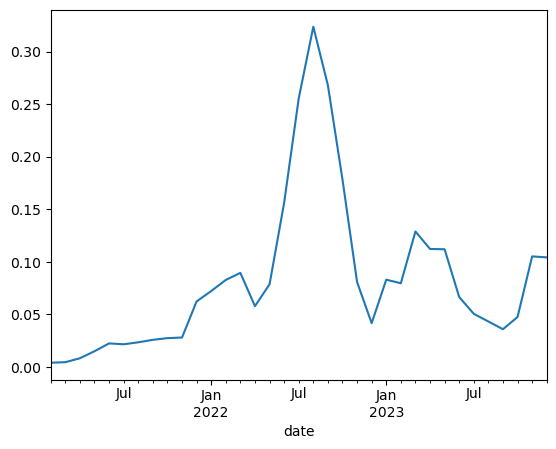

In [122]:
monthly_df.USDC_transactions_28_day.plot()

<Axes: xlabel='date'>

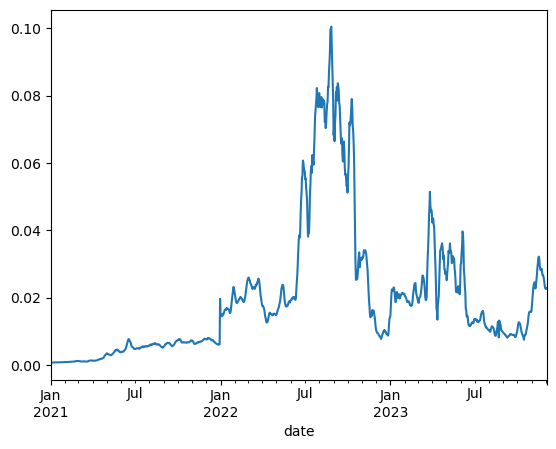

In [96]:
df3.USDC_transactions_7_day.plot()

<Axes: xlabel='date'>

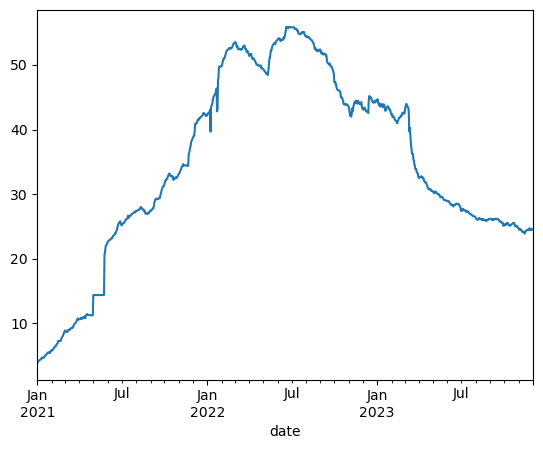

In [97]:
df3.marketcap.plot()

<Axes: xlabel='date'>

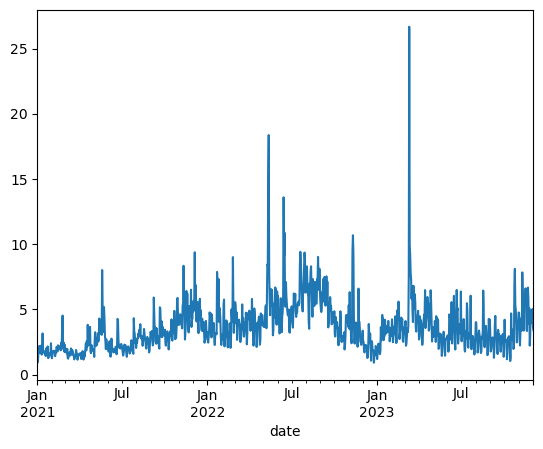

In [103]:
df3.volume.plot()

In [74]:
import pandas as pd

# Create a DataFrame to hold coefficients and t-values
results_df = pd.DataFrame()

for i, model in enumerate(models):
    # Store the coefficients and t-values in temporary DataFrames
    coefs = pd.DataFrame(model.params, columns=[f'model{i+1}_coef'])
    tvals = pd.DataFrame(model.tvalues, columns=[f'model{i+1}_tval'])
    
    # Concatenate the coefficients and t-values horizontally
    temp_df = pd.concat([coefs, tvals], axis=1)
    
    # Merge with the results DataFrame
    if results_df.empty:
        results_df = temp_df
    else:
        results_df = results_df.merge(temp_df, left_index=True, right_index=True, how='outer')

# Now display or print the DataFrame with coefficients and t-values
results_df

,model1_coef,model1_tval,model2_coef,model2_tval,model3_coef,model3_tval,model4_coef,model4_tval
Intercept,0.530307,1.768596,1.429629e-13,3.104673,1.088715e-13,0.638583,1.429629e-13,3.104673
USDC_counterparties_7_day,NaN,NaN,2.746185e-07,3.104878,NaN,NaN,2.746185e-07,3.104878
USDC_counterparties_7_day_change,NaN,NaN,NaN,NaN,3.232913e-07,0.638506,NaN,NaN
USDC_gross_transfers_7_day,NaN,NaN,6.563633e-14,2.019637,NaN,NaN,6.563633e-14,2.019637
USDC_gross_transfers_7_day_change,NaN,NaN,NaN,NaN,2.512232e-14,0.391840,NaN,NaN
USDC_net_transfers_7_day,NaN,NaN,-6.562228e-14,-2.019273,NaN,NaN,-6.562228e-14,-2.019273
USDC_net_transfers_7_day_change,NaN,NaN,NaN,NaN,-2.511247e-14,-0.391684,NaN,NaN
USDC_transactions_7_day,NaN,NaN,-2.357809e-08,-4.070638,NaN,NaN,-2.357809e-08,-4.070638
USDC_transactions_7_day_change,NaN,NaN,NaN,NaN,5.358869e-09,0.342024,NaN,NaN
btc_log_change,-0.891025,-0.719792,NaN,NaN,NaN,NaN,1.804213e-14,3.126991


In [39]:
weekly_df.tail(1).transpose()

date,2023-12-03
btc,40028.840000
marketcap,24.512976
volume,30.640012
volumeUSDT,239.847308
gross,2.468455
marketcapUSDT,89.616692
btc_log_change,0.066046
volume_change,-1.867061
volumeUSDT_change,-15.558324
marketcap_change,-0.134874


<Axes: xlabel='date'>

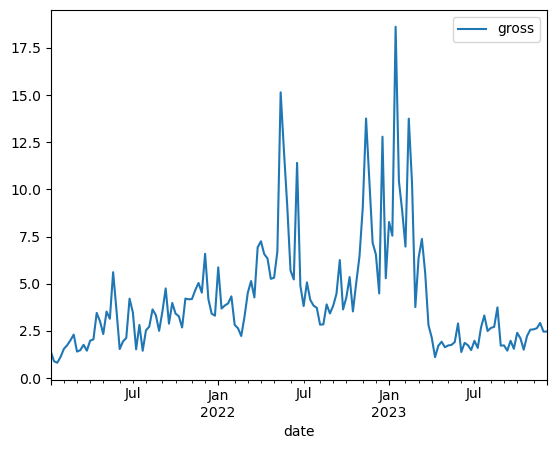

In [11]:
weekly_df[['gross']].plot()

In [12]:



# Calculate the weekly changes
weekly_df = df.resample('W').last()  # Use the last observation to represent the week
weekly_df['btc_log_change'] = np.log(weekly_df['btc']).diff()
weekly_df['volume_change'] = weekly_df['volume'].diff()
weekly_df['marketcap_change'] = weekly_df['marketcap'].diff()

# Drop the NA values generated by diff
weekly_df.dropna(subset=['btc_log_change', 'volume_change', 'marketcap_change'], inplace=True)

# Standardize changes
weekly_df['btc_log_change_std'] = (weekly_df['btc_log_change'] - weekly_df['btc_log_change'].mean()) / weekly_df['btc_log_change'].std()
weekly_df['volume_change_std'] = (weekly_df['volume_change'] - weekly_df['volume_change'].mean()) / weekly_df['volume_change'].std()


# Create the post-March 2023 dummy variable
threshold_date = pd.to_datetime('2023-03-13')
weekly_df['post_march_2023'] = (weekly_df.index > threshold_date).astype(int)

# Interaction terms
weekly_df['post_march_2023_btc'] = weekly_df['post_march_2023'] * weekly_df['btc_log_change']
weekly_df['post_march_2023_volume'] = weekly_df['post_march_2023'] * weekly_df['volume_change']

weekly_df['post_march_2023_btc_std'] = weekly_df['post_march_2023'] * weekly_df['btc_log_change_std']
weekly_df['post_march_2023_volume_std'] = weekly_df['post_march_2023'] * weekly_df['volume_change_std']

# Define regression models
model1 = ols('marketcap_change ~ btc_log_change + volume_change', data=weekly_df).fit()
model2 = ols('marketcap_change ~ btc_log_change + volume_change + post_march_2023 + post_march_2023_btc + post_march_2023_volume', data=weekly_df).fit()

# Use stargazer to display the regression tables
sg = Stargazer([model1, model2])


sg

In [ ]:
df.describe()

In [ ]:



# Calculate the weekly changes
monthly_df = df.resample('M').last()  # Use the last observation to represent the week
monthly_df['btc_log_change'] = np.log(monthly_df['btc']).diff()
monthly_df['volume_change'] = monthly_df['volume'].diff()
monthly_df['marketcap_change'] = monthly_df['marketcap'].diff()

# Drop the NA values generated by diff
monthly_df.dropna(subset=['btc_log_change', 'volume_change', 'marketcap_change'], inplace=True)

# Standardize changes
monthly_df['btc_log_change_std'] = (monthly_df['btc_log_change'] - monthly_df['btc_log_change'].mean()) / monthly_df['btc_log_change'].std()
monthly_df['volume_change_std'] = (monthly_df['volume_change'] - monthly_df['volume_change'].mean()) / monthly_df['volume_change'].std()


# Create the post-March 2023 dummy variable
threshold_date = pd.to_datetime('2023-03-13')
monthly_df['post_march_2023'] = (monthly_df.index > threshold_date).astype(int)

# Interaction terms
monthly_df['post_march_2023_btc'] = monthly_df['post_march_2023'] * monthly_df['btc_log_change']
monthly_df['post_march_2023_volume'] = monthly_df['post_march_2023'] * monthly_df['volume_change']

monthly_df['post_march_2023_btc_std'] = monthly_df['post_march_2023'] * monthly_df['btc_log_change_std']
monthly_df['post_march_2023_volume_std'] = monthly_df['post_march_2023'] * monthly_df['volume_change_std']

# Define regression models
model1 = ols('marketcap_change ~ btc_log_change + volume_change', data=monthly_df).fit()
model2 = ols('marketcap_change ~ btc_log_change + volume_change + post_march_2023 + post_march_2023_btc + post_march_2023_volume', data=weekly_df).fit()

# Use stargazer to display the regression tables
sg = Stargazer([model1, model2])
latex_output = sg.render_latex()
with open('regression_output.tex', 'w') as file:
    file.write(stargazer.render_latex())

sg

In [ ]:

fig = px.scatter(
    weekly_df,
    x='btc_log_change',
    y='marketcap_change',
    title='Weekly Log Change of BTC vs. Change in Market Cap',
    labels={'btc_log_change': 'BTC Weekly Log Change', 'marketcap_change': 'Market Cap Change'}
)

# Show the plot
fig.show()

In [ ]:
import plotly.graph_objects as go

# Fit a line to the points
x = weekly_df['btc_log_change']
y = weekly_df['marketcap_change']
coefficients = np.polyfit(x, y, 1)  # Fit a 1st degree polynomial (line) to the data
poly_line = np.poly1d(coefficients)
line_space = np.linspace(x.min(), x.max(), len(weekly_df))

# Create the scatter plot with a regression line
fig = go.Figure()

# Scatter plot of all points with hover text
fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Weekly Change', text=weekly_df.index, hoverinfo='text+x+y'))

# Scatter plot with just the last point highlighted in red
fig.add_trace(go.Scatter(x=[x.iloc[-1]], y=[y.iloc[-1]], mode='markers', marker=dict(color='red', size=10), name='Last Point', text=[weekly_df.index[-1]], hoverinfo='text+x+y'))

# Add the linear regression line
fig.add_trace(go.Scatter(x=line_space, y=poly_line(line_space), mode='lines', name='Fit'))

# Customize the layout
fig.update_layout(
    title='Weekly Log Change of BTC vs. Change in USDC Market Cap with Linear Fit',
    xaxis_title='BTC Weekly Log Change',
    yaxis_title='USDC Market Cap Change',
)

# Show the plot
fig.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.io import write_image

# Assuming df is your DataFrame and has been properly manipulated as above

# ... [Insert previously discussed code here to generate 'weekly_df' and the traces]

# [Continue from above...]

# Add layout customizations and size in inches. Width and Height are specified in pixels (1 inch = 72 pixels)
fig.update_layout(
    title='Weekly Log Change of BTC Price vs. Change in USDC Market Cap',
    xaxis_title='BTC Weekly Log Change',
    yaxis_title='Market Cap Change',
    width=10*72,   # 5 inches
    height=7*72    # 5 inches
)

# Export as a PDF
write_image(fig, 'weekly_change_scatter.pdf', format='pdf')



In [ ]:
fig = px.line(df, y='marketcap', title='Market Capitalization Over Time')
fig.show()

In [100]:
import plotly.graph_objects as go

# Fit a line to the points
x = weekly_df['USDC_transactions_7_day']
y = weekly_df['marketcap_change']
coefficients = np.polyfit(x, y, 1)  # Fit a 1st degree polynomial (line) to the data
poly_line = np.poly1d(coefficients)
line_space = np.linspace(x.min(), x.max(), len(weekly_df))

# Create the scatter plot with a regression line
fig = go.Figure()

# Scatter plot of all points with hover text
fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Weekly Change', text=weekly_df.index, hoverinfo='text+x+y'))

# Scatter plot with just the last point highlighted in red
fig.add_trace(go.Scatter(x=[x.iloc[-1]], y=[y.iloc[-1]], mode='markers', marker=dict(color='red', size=10), name='Last Point', text=[weekly_df.index[-1]], hoverinfo='text+x+y'))

# Add the linear regression line
fig.add_trace(go.Scatter(x=line_space, y=poly_line(line_space), mode='lines', name='Fit'))

# Customize the layout
fig.update_layout(
    title='',
    xaxis_title='USDC_transactions_7_day',
    yaxis_title='marketcap_change',
)

# Show the plot
fig.show()

In [99]:
import plotly.graph_objects as go

# Split the dataset into pre and post-March 2023
threshold_date = pd.to_datetime('2023-03-13')
pre_march = weekly_df[weekly_df.index < threshold_date]
post_march = weekly_df[weekly_df.index >= threshold_date]

# Fit a line to the points for the entire period
x = weekly_df['USDC_transactions_7_day']
y = weekly_df['marketcapUSDT_change']
coefficients = np.polyfit(x, y, 1)  # Fit a 1st degree polynomial (line) to the data
poly_line = np.poly1d(coefficients)
line_space = np.linspace(x.min(), x.max(), len(weekly_df))

# Create the scatter plot with a regression line
fig = go.Figure()

# Scatter plot of pre-March points (default color)
fig.add_trace(go.Scatter(
    x=pre_march['USDC_transactions_7_day'],
    y=pre_march['marketcapUSDT_change'],
    mode='markers',
    name='Pre-March Change',
    text=pre_march.index,
    hoverinfo='text+x+y'
))

# Scatter plot of post-March points (orange color)
fig.add_trace(go.Scatter(
    x=post_march['USDC_transactions_7_day'],
    y=post_march['marketcapUSDT_change'],
    mode='markers',
    name='Post-March Change',
    text=post_march.index,
    hoverinfo='text+x+y',
    marker=dict(color='orange')
))

# Scatter plot with just the last point highlighted in red
fig.add_trace(go.Scatter(
    x=[x.iloc[-1]],
    y=[y.iloc[-1]],
    mode='markers',
    marker=dict(color='red', size=10),
    name='Last Point',
    text=[weekly_df.index[-1]],
    hoverinfo='text+x+y'
))

# Add the linear regression line
fig.add_trace(go.Scatter(
    x=line_space,
    y=poly_line(line_space),
    mode='lines',
    name='Fit'
))

# Customize the layout
fig.update_layout(
    title='Weekly "USDC_transactions_7_day" vs. "marketcapUSDT_change" with Regression Line',
    xaxis_title='Gross',
    yaxis_title='Market Cap Change',
)

# Show the plot
fig.show()

In [33]:
import plotly.graph_objects as go

# Split the dataset into pre and post-March 2023
threshold_date = pd.to_datetime('2023-03-13')
pre_march = weekly_df[weekly_df.index < threshold_date]
post_march = weekly_df[weekly_df.index >= threshold_date]

# Fit a line to the points for the entire period
x = weekly_df['gross']
y = weekly_df['marketcapUSDT_change']
coefficients = np.polyfit(x, y, 1)  # Fit a 1st degree polynomial (line) to the data
poly_line = np.poly1d(coefficients)
line_space = np.linspace(x.min(), x.max(), len(weekly_df))

# Create the scatter plot with a regression line
fig = go.Figure()

# Scatter plot of pre-March points (default color)
fig.add_trace(go.Scatter(
    x=pre_march['gross'],
    y=pre_march['marketcapUSDT_change'],
    mode='markers',
    name='Pre-March Change',
    text=pre_march.index,
    hoverinfo='text+x+y'
))

# Scatter plot of post-March points (orange color)
fig.add_trace(go.Scatter(
    x=post_march['gross'],
    y=post_march['marketcapUSDT_change'],
    mode='markers',
    name='Post-March Change',
    text=post_march.index,
    hoverinfo='text+x+y',
    marker=dict(color='orange')
))

# Scatter plot with just the last point highlighted in red
fig.add_trace(go.Scatter(
    x=[x.iloc[-1]],
    y=[y.iloc[-1]],
    mode='markers',
    marker=dict(color='red', size=10),
    name='Last Point',
    text=[weekly_df.index[-1]],
    hoverinfo='text+x+y'
))

# Add the linear regression line
fig.add_trace(go.Scatter(
    x=line_space,
    y=poly_line(line_space),
    mode='lines',
    name='Fit'
))

# Customize the layout
fig.update_layout(
    title='Weekly "gross" vs. "marketcapUSDT_change" with Regression Line',
    xaxis_title='Gross',
    yaxis_title='Market Cap Change',
)

# Show the plot
fig.show()